In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
np.set_printoptions(threshold=np.inf)

## References

https://cse.lab.imtlucca.it/~bemporad/publications/papers/ijc_rtiltv.pdf

https://web.stanford.edu/~boyd/papers/pdf/fast_mpc.pdf

https://www.imtek.de/professuren/systemtheorie/events/dateien/directshootingmethods

https://www.matthewpeterkelly.com/tutorials/trajectoryOptimization/cartPoleCollocation.svg#frame1114

In [3]:
def rk4(x_init, t_init, dt, f):
    # f = f(t, x) - the function representing the time derivative of the state vector, x
    # returns the next state
    k1 = f(t_init, x_init)
    k2 = f(t_init + dt/2, x_init + dt * k1/2)
    k3 = f(t_init + dt/2, x_init + dt * k2/2)
    k4 = f(t_init + dt, x_init + dt * k3)

    return x_init + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)


In [4]:
def spring_dynamics(t, x, m=1.0, k=5.0, c=1.0):
    # x = [position, velocity]
    return np.array([x[1], -(k / m) * x[0] - (c / m) * x[1]])

In [5]:
def periodic_driver(t, x, f=1.5, w=0.5/np.pi):
    return np.array([0, f * np.cos(w * t)])

In [6]:
def affine_linear_dynamics(t, x, A, p):
    # t = time
    # x = state, shape [n]
    # A = linearized dynamics, shape [n, n]
    # p = affine term, shape [n]
    return np.dot(A, x) + p

In [7]:
def driven_spring_example():
    x_init = [2.0, -1.0]
    xs = []
    xs.append(copy.copy(x_init))
    dt = 0.01
    undamped_spring_dynamics = lambda t, y: spring_dynamics(t, y, 1.0, 5.0, 0.0) + periodic_driver(t, y)
    
    for i in range(2000):
        xs.append(rk4(xs[-1], dt * i, dt, undamped_spring_dynamics))

    return xs

In [8]:
def damped_spring_example():
    y_init = [1.0, -1.0]
    ys = []
    ys.append(copy.copy(y_init))
    dt = 0.01
    damped_spring_dynamics = lambda t, y: spring_dynamics(t, y, 1.0, 5.0, 2.0)
    
    for i in range(20000):
        ys.append(rk4(ys[-1], dt * i, dt, damped_spring_dynamics))

    return ys

In [9]:
def cartpole_dynamics(t, z, u, u_max=1.0, m_cart=1.0, m_pend=1.0, l_pend=1.0):
    # z = [cart_pos, pend_angle, cart_pos_speed, pend_angle_speed]
    # u = force exerted on cart, clamped between +/-u_max
    u = np.clip(u, -u_max, u_max)
    cosz1 = np.cos(z[1])
    sinz1 = np.sin(z[1])
    alpha = (m_pend + m_cart) / (m_pend * l_pend)
    g = 9.8
    denom = (cosz1 * cosz1 - alpha)

    return np.array(
        [
            z[2],
            z[3],
            (-g * sinz1 * cosz1 - u - (z[3]**2) * sinz1) / denom,
            (alpha * g * sinz1 + u * cosz1 + (z[3]**2 * sinz1 * cosz1)) / denom
         ]
    )

In [10]:
def cartpole_demo():
    z_init = [1.0, 2.0 * np.pi / 3.0, 0.0, 1.0]
    zs = []
    zs.append(copy.copy(z_init))
    dt = 0.01
    unforced_dynamics = lambda t, y : cartpole_dynamics(t, y, 0.0)
    
    for i in range(2000):
        zs.append(rk4(zs[-1], dt * i, dt, unforced_dynamics))

    def pendulum_position(z, l_pend):
        # z = [cart_pos, pend_angle, cart_pos_speed, pend_angle_speed]
        return np.array([z[0] + l_pend * np.sin(z[1]), -l_pend * np.cos(z[1])])
    
    pendulum_positions = [pendulum_position(z, 1.0) for z in zs]

    fig = plt.figure()
    ax = fig.add_subplot()
    plt.plot([p[0] for p in pendulum_positions], [p[1] for p in pendulum_positions])
    # ax.set_aspect('equal', adjustable='box')
    ax.axis('equal')
    plt.show()

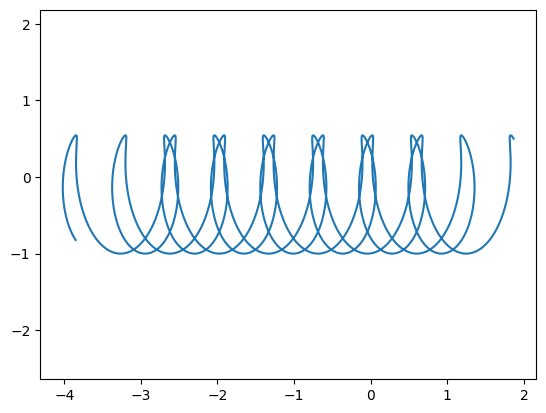

In [11]:
cartpole_demo()

The nonlinear system dynamics is governed by

\begin{equation}
    \frac{dz}{dt} = f(z, u)
\end{equation}

\begin{equation}
    f(z, u) : \mathbb{R}^n \times \mathbb{R}^m \rightarrow \mathbb{R}^n
\end{equation}

Linearizing $f(z, u)$ around a set point $(z_k, u_k)$ gives

\begin{equation}
    f(z, u) \approx f(z_k, u_k) + \frac{\partial f(z_k, u_k)}{\partial z} (z - z_k) + \frac{\partial f(z_k, u_k)}{\partial u}(u - u_k) = f(z_k, u_k) + A(z - z_k) + B(u - u_k)
\end{equation}

\begin{equation}
    f(z, u) \approx f(z_k, u_k) - A z_k - B u_k + A z + B u
\end{equation}

In [12]:
def linearized_cartpole_dynamics(t, z, u, u_max=1.0, m_cart=1.0, m_pend=1.0, l_pend=1.0):
    # z = [cart_pos, pend_angle, cart_pos_speed, pend_angle_speed]
    # u = force exerted on cart, clamped between +/-u_max
    # linearizes the cartpole dynamics about `z` and `u`, returns the `A` and `b` matrices
    #    `z_dot = f(t, z, u) ~ f(t_0, z_0, u_0) + grad(f, z)(t_0, z_0, u_0) ^ T (z - z_0) + grad(f, u)(t_0, z_0, u_0) ^ T (u - u_0)
    #    `A` - Jacobian of cartpole dynamics with respect to state, `z`
    #    `r` - affine part of the linear approximation of cartpole dynamics
    #    `b` - Jacobian of cartpole dynamics with respect to control input, `u`
    # Returns `A`, `b`, `r`
    A = np.zeros((4, 4))
    b = np.zeros(4)

    cosz1 = np.cos(z[1])
    sinz1 = np.sin(z[1])
    alpha = (m_pend + m_cart) / (m_pend * l_pend)
    g = 9.8
    denom = (cosz1 * cosz1 - alpha)

    A[0, 2] = 1.0
    A[1, 3] = 1.0
    A[2, 1] = ((g * sinz1 * sinz1 - g * cosz1 * cosz1 - (z[3] ** 2) * cosz1) / denom) + 2.0 * ((sinz1 * cosz1 * (-g * sinz1 * cosz1 - u * cosz1 + (z[3] ** 2) * sinz1 * cosz1)) / (denom * denom))
    A[2, 3] = -2.0 * z[3] * sinz1 / denom
    A[3, 1] = ((alpha * g * cosz1 - u * sinz1 - (z[3] ** 2) * (sinz1 * sinz1 - cosz1 * cosz1)) / denom) + 2.0 * ((sinz1 * cosz1) * (alpha * g * sinz1 + u * cosz1 + (z[3] ** 2) * sinz1 * cosz1) / (denom * denom))
    A[3, 3] = 2.0 * z[3] * sinz1 * cosz1 / denom

    b[2] = -1.0 / denom
    b[3] = -cosz1 / denom

    r = cartpole_dynamics(t, z, u, u_max, m_cart, m_pend, l_pend) - np.dot(A, z) - b * u

    return A, b, r

## How I want to do this
$N + 1$ timesteps going from $[0, N]$

$T$ time length

$dt = T / N$ timestep

\begin{equation}
    z = \begin{bmatrix}
        x_c, \\
        \phi, \\
        \dot{x_c}, \\
        \dot{\phi}
    \end{bmatrix} \in \mathbb{R}^4
\end{equation}

where $x_c$ is the horizontal cart position, and $\phi$ is the angle of the pendulum relative to the $-\hat{y}$ axis

$u \in \mathbb{R}$

One control input, $u_i$, for each timestep $~\forall i \in [0, N-1]$

One state variable, $z_i$, for each timestep $~\forall i \in [0, N]$

Decision variable, $x \in \mathbb{R}^{N + 1 + 4 (N + 1)} = \mathbb{R}^{5 (N + 1)}$

Decision variable is patterned as 

\begin{equation}
    x = \begin{bmatrix}
        u_0, \\
        u_1, \\
        \vdots \\
        u_{N-1}, \\
        u_{N}, \\
        z_0, \\
        z_1, \\
        \vdots \\
        z_{N-1}, \\
        z_{N}
    \end{bmatrix}
\end{equation}

<!-- \begin{equation}
    x = \begin{bmatrix}
        z_0, \\
        u_0, \\
        z_1, \\
        u_1, \\
        \vdots \\
        z_{N-1}, \\
        u_{N-1}, \\
        z_{N}
    \end{bmatrix}
\end{equation} -->

The residual vector is the result of the KKT conditions applied to a convex optimization problem (convex objective function with equality constraints)

\begin{equation}
    \text{residual} = r(x, v; A, b, f) = \begin{pmatrix}
        \nabla_x f(x) + A^T \nu \\
        Ax - b
    \end{pmatrix}
\end{equation}

Want to find where the residual equals zero, so use Newton's method.

The $A$, $b$, $f$ terms in the residual add more noise than clarity, so just keep in mind that $r = r(x, v; A, b, f)$

\begin{equation}
    r(w, y) \approx r(x, v) + (\nabla_{x, v} r(x, v))^T
    \begin{pmatrix}
            w - x\\
            y - v
    \end{pmatrix} = r(x, v) + \begin{pmatrix}
        \nabla_x r(x, v)^T \\
        \nabla_v r(x, v)^T
    \end{pmatrix} \begin{pmatrix}
        w - x\\
        y - v
    \end{pmatrix}
\end{equation}

and if $w = x + \Delta x$, $y = v + s \Delta v$ this becomes

\begin{equation}
    r(x + \Delta x, y = v + \Delta v) \approx r(x, v) + \begin{pmatrix}
        \nabla_x r(x, v)^T \\
        \nabla_v r(x, v)^T
    \end{pmatrix} \begin{pmatrix}
        \Delta x\\
        \Delta v
    \end{pmatrix} = r(x, v) + \begin{pmatrix}
        \nabla_x^2 f(x) & A^T\\
        A & 0
    \end{pmatrix} \begin{pmatrix}
        \Delta x\\
        \Delta v
    \end{pmatrix}
\end{equation}

In [103]:
def build_A_and_c(F, b, f, z_init, z_final, N, dt):
    # Builds the parameters of the linear equation Ax = c from the
    # parameters of an LTI dynamical system. `A` and `c` represent
    # collocation constraints on the dynamics of a system.
    # This is for LTI dynamical systems where z_dot = Fz + bu + f
    #    F is a matrix
    #    b is a vector
    #    z is a vector
    #    u is a scalar
    # F - F matrix of z_dot = Fz + bu + f
    # b - b vector of z_dot = Fz + bu + f
    # f - f vector of z_dot = Fz + bu + f
    # N - the number of time points
    # dt - delta time between time points

    state_vec_size = np.shape(F)[0]
    # `state_vec_size * 2` extra rows are tacked on to `A` and `c`
    # to handle the boundary constraints on `z_0` and `z_N`
    A = np.zeros((state_vec_size * (N + 2), (state_vec_size + 1) * (N + 1)))
    c = np.zeros(state_vec_size * (N + 2))

    # The index in the vector of decision variables where the first element of the
    # state vector from the dynamical system at the first time step appears
    control_input_offset = N + 1
    for i in range(N):
        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            i
        ] = b * dt / 2.0

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            i + 1
        ] = b * dt / 2.0

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + i * state_vec_size : control_input_offset + i * state_vec_size + state_vec_size
        ] = F * dt / 2.0 + np.eye(state_vec_size)

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + (i + 1) * state_vec_size : control_input_offset + (i + 1) * state_vec_size + state_vec_size
        ] = F * dt / 2.0 - np.eye(state_vec_size)

        c[i * state_vec_size : i * state_vec_size + state_vec_size] = -f * dt

    A[
        N * state_vec_size: N * state_vec_size + state_vec_size,
        control_input_offset + 0: control_input_offset + 0 + state_vec_size
    ] = np.eye(state_vec_size)

    c[N * state_vec_size: N * state_vec_size + state_vec_size] = z_init

    A[
        (N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size,
        control_input_offset + N * state_vec_size: control_input_offset + N * state_vec_size + state_vec_size
    ] = np.eye(state_vec_size)

    c[(N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size] = z_final

    # print("last two constraints in A:\n", A[N * state_vec_size:, :])
    # print("last two constraints in c:\n", c[N * state_vec_size:])
    
    return A, c

In [141]:
def build_A_and_c_mat_exp(F, b, f, z_init, z_final, N, dt):
    # Builds the parameters of the linear equation Ax = c from the
    # parameters of an LTI dynamical system using a Taylor series
    # expansion of the matrix exponential solution to the dynamic equation
    # z_dot = F * z + b * u + f. `A` and `c` represent
    # collocation constraints on the dynamics of a system.
    # This is for LTI dynamical systems where z_dot = Fz + bu + f
    #    F is a matrix
    #    b is a vector
    #    z is a vector
    #    u is a scalar
    # F - F matrix of z_dot = Fz + bu + f
    # b - b vector of z_dot = Fz + bu + f
    # f - f vector of z_dot = Fz + bu + f
    # N - the number of time points
    # dt - delta time between time points

    def mat_exp_ish(A, dt):
        return np.eye(np.shape(A)[0], np.shape(A)[1]) + A * dt + 0.5 * np.dot(A, A) * (dt**2)

    def some_funk(A, dt):
        return dt + 0.5 * A * (dt**2) + (1.0/6.0) * np.dot(A, A) * (dt ** 3)

    phi = mat_exp_ish(F, dt)
    phi_integ = some_funk(F, dt)

    state_vec_size = np.shape(F)[0]
    # `state_vec_size * 2` extra rows are tacked on to `A` and `c`
    # to handle the boundary constraints on `z_0` and `z_N`
    A = np.zeros((state_vec_size * (N + 2), (state_vec_size + 1) * (N + 1)))
    c = np.zeros(state_vec_size * (N + 2))

    # The index in the vector of decision variables where the first element of the
    # state vector from the dynamical system at the first time step appears
    control_input_offset = N + 1
    for i in range(N):
        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            i
        ] = -np.dot(phi_integ, b)

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + i * state_vec_size : control_input_offset + i * state_vec_size + state_vec_size
        ] = -phi

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + (i + 1) * state_vec_size : control_input_offset + (i + 1) * state_vec_size + state_vec_size
        ] = np.eye(state_vec_size)

        c[i * state_vec_size : i * state_vec_size + state_vec_size] = np.dot(phi_integ, f)

    A[
        N * state_vec_size: N * state_vec_size + state_vec_size,
        control_input_offset + 0: control_input_offset + 0 + state_vec_size
    ] = np.eye(state_vec_size)

    c[N * state_vec_size: N * state_vec_size + state_vec_size] = z_init

    A[
        (N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size,
        control_input_offset + N * state_vec_size: control_input_offset + N * state_vec_size + state_vec_size
    ] = np.eye(state_vec_size)

    c[(N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size] = z_final

    # print("last two constraints in A:\n", A[N * state_vec_size:, :])
    # print("last two constraints in c:\n", c[N * state_vec_size:])
    
    return A, c

In [104]:
def build_kkt_matrix(H, A):
    # H - Hessian of the quadratic objective function with respect to the
    #     decision variables. (This is probably a square matrix that only
    #     touches the `u` decision variables).
    # A - Equality constraint matrix

    K = np.zeros(
        (np.shape(H)[0] + np.shape(A)[0], np.shape(H)[1] + np.shape(A)[0])
    )

    K[
        0: np.shape(H)[0],
        0: np.shape(H)[1]
    ] = H
    K[
        np.shape(H)[0]: np.shape(H)[0] + np.shape(A)[0],
        0: np.shape(A)[1]
    ] = A
    K[
        0: np.shape(A)[1],
        np.shape(H)[0]: np.shape(H)[0] + np.shape(A)[0]
    ] = np.transpose(A)

    return K

In [105]:
def calculate_obj_grad_hess(Q, x, t, u_min, u_max, N, grad_hess = True):
    # Q - quadratic cost matrix (should be square with one dimension
    #     equal to the shape of `x`
    # x - decision variable made up of control inputs (at the top) and 
    #     dynamical states (at the bottom)
    # t - value for interior point method

    u_vals = x[0:(N + 1)]
    
    obj = 0.5 * np.dot(np.dot(Q, x), x) - (1.0/t) * np.sum(np.log(u_max - u_vals)) - (1.0/t) * np.sum(np.log(u_vals - u_min))

    if not grad_hess:
        return obj, None, None

    grad = np.zeros_like(x)

    grad[0:(N + 1)] = np.dot(Q, x)[0: (N + 1)] + (1.0/t) * ((-1.0 / (u_vals - u_min)) + (1.0 / (u_max - u_vals)))

    hess = np.zeros((np.shape(x)[0], np.shape(x)[0]))
    hess[0:(N + 1), 0:(N + 1)] = Q[0:(N + 1), 0:(N + 1)] + (1.0/t) * np.diag((1.0 / ((u_vals - u_min) * (u_vals - u_min))) + (1.0 / ((u_max - u_vals) * (u_max - u_vals))))

    return obj, grad, hess

In [106]:
def calc_residual(x, v, A, c, Q, t, u_min, u_max, N):
    obj, grad, _ = calculate_obj_grad_hess(Q, x, t, u_min, u_max, N)

    return np.hstack(
        [
            grad + np.dot(np.transpose(A), v),
            np.dot(A, x) - c
        ]
    )

# def infeasible_newton(x_init, v_init, barrier_t, Q, u_min, u_max, z_init, z_final, F, f, b, N, dt, max_iters=100, eps=1e-3, alpha=0.5, beta=0.9):
def infeasible_newton(x_init, v_init, barrier_t, Q, A, c, u_min, u_max, N, max_iters=100, eps=1e-3, alpha=0.5, beta=0.9):
    # x_init = initial decision variable, x = [u0, u1, ..., uN, z0, z1, ..., zN]
    # v_init = initial equality constraint langrange multiplier, v.shape = [(N + 2) * state_vec_size] (where state_vec_size is the
    #          dimension of a single state variable for the system dynamics
    # t_init = initial interior point barrier method factor
    # Q      = quadratic cost coefficients, Q.shape = [(state_vec_size + 1) * (N + 1), (state_vec_size + 1) * (N + 1)]
    # u_min  = scalar minimum input value
    # u_max  = scalar maximum input value
    # z_init = initial dynamic state constraint (constraint says z0 = z_init must be true)
    # z_final = final dynamic state constraint (constraint says zN = z_final must be true)
    # F      = Jacobian of first-order ODE (describing system dynamics) with respect to z
    # f      = constant value from linearizing dynamics about (z_0, u_0)
    # b      = Jacobian of first-order ODE (describing system dynamics) with respect to u
    # N      = The number of non-zero time points in the trajectory optimization
    #          [t_0, t_1, t_2, ..., t_{N-2}, t_{N-1}, T_{N}]

    assert(len(np.shape(x_init)) == 1)
    assert(len(np.shape(u_min)) == 0)
    assert(len(np.shape(u_max)) == 0)
    assert(np.shape(Q) == (np.shape(x_init)[0], np.shape(x_init)[0]))
    assert(N > 0)

    x = copy.deepcopy(x_init)
    v = copy.deepcopy(v_init)

    residual = calc_residual(x, v, A, c, Q, barrier_t, u_min, u_max, N)

    num_iters = 0
    
    while np.linalg.norm(residual) >= eps and (num_iters < max_iters):
        # calculate delta_x, delta_v from the primal+dual Newton step
        obj, grad, hess = calculate_obj_grad_hess(Q, x, barrier_t, u_min, u_max, N)

        residual = calc_residual(x, v, A, c, Q, barrier_t, u_min, u_max, N)
        K = build_kkt_matrix(hess, A)

        print("residual: ", np.linalg.norm(residual))

        delta_x_v = np.linalg.solve(K, -residual)

        delta_x = delta_x_v[0:x_init.shape[0]]
        delta_v = delta_x_v[x_init.shape[0]:]

        # backtracking line search on the l2 norm of the residual and inequality
        # constrained decision variables to get step size
        s = 1.0
        while np.any((x + s * delta_x)[0:(N + 1)] < u_min) or np.any((x + s * delta_x)[0:(N + 1)] > u_max) or np.linalg.norm(calc_residual(x + s * delta_x, v + s * delta_v, A, c, Q, barrier_t, u_min, u_max, N)) > (1 - alpha * s) * np.linalg.norm(residual):
            s = s * beta

        #print("step size: ", s)
        
        x = x + s * delta_x
        v = v + s * delta_v

        print("step: ", s)
        print("obj: ", obj)
        
        num_iters += 1

    print("num iters: ", num_iters)
    print("residual: ", np.linalg.norm(calc_residual(x, v, A, c, Q, barrier_t, u_min, u_max, N)))
    print("constraint satisfaction: ", np.linalg.norm(np.dot(A, x) - c))
    print("constraint satisfaction: ", np.dot(A, x) - c)

    return x


In [143]:
state_vec_size = 4
# Number of timesteps
N = 32
# Total amount of time
T = 3
# delta time between steps
dt = T / N

Q = np.zeros(((N + 1) * (state_vec_size + 1), (N + 1) * (state_vec_size + 1)))
Q[0:(N + 1), 0:(N + 1)] = np.eye(N + 1)
u_min = -1.0
u_max = 1.0

# Initial state, used for linearizing dynamics
# z_0 = np.array([0.0, 2 * np.pi / 3.0, 0.0, 0.0])
z_0 = np.array([0.0, 0.0, 0.0, 0.0])
u_0 = (u_max + u_min) / 2.0
t_0 = 0.0

F, b, f = linearized_cartpole_dynamics(t_0, z_0, u_0, u_max)

z_final = np.array([1.0, np.pi, 0.0, 0.0])

A, c = build_A_and_c_mat_exp(F, b, f, z_0, z_final, N, dt)

np.savetxt("dynamics_A.csv", A, delimiter=",")

# zs for warm-starting infeasible newton
delta_tau = (1.0 / N)
warm_zs = [(1 - i * delta_tau) * z_0 + i * delta_tau * z_final for i in range(N + 1)]
warm_us = [0.000,] * (N + 1)

print("z_0: ", warm_zs[0])
print("z_f: ", warm_zs[-1])

x_init = np.hstack(warm_us + warm_zs)

#print("x init:", x_init)

v_init = np.ones(state_vec_size * (N + 2)) * 0.01
barrier_t = 10.0

print("x init shape:", np.shape(x_init))
print("Q shape: ", np.shape(Q))

z_0:  [0. 0. 0. 0.]
z_f:  [1.         3.14159265 0.         0.        ]
x init shape: (165,)
Q shape:  (165, 165)


In [144]:
      # infeasible_newton(x_init, v_init, t_init, Q, u_min, u_max, z_0, z_final, F, f, b, N, dt, max_iters=100
# x_out = infeasible_newton(x_init, v_init, barrier_t, Q, u_min, u_max, z_0, z_final, F, f, b, N, dt, 100)
x_out = infeasible_newton(x_init, v_init, barrier_t, Q, A, c, u_min, u_max, N, max_iters=100)

residual:  20.63192671573528
step:  0.6561000000000001
obj:  0.0
residual:  7.190145293885366
step:  0.6561000000000001
obj:  4.617192899446279
residual:  4.715644431884591
step:  0.9
obj:  9.273926758216042
residual:  2.4002358820806253
step:  1.0
obj:  12.772645731191421
residual:  0.3103379278085633
step:  1.0
obj:  13.246224058351244
residual:  0.011523295481940058
step:  1.0
obj:  13.245360925477774
residual:  3.6392122250089195e-05
step:  1.0
obj:  13.245359215277844
num iters:  7
residual:  5.710015943612174e-10
constraint satisfaction:  3.7541027028866924e-15
constraint satisfaction:  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.77549177e-17
  6.93889390e-18 -2.77555756e-17  1.11022302e-16 -2.77555756e-17
  5.55111512e-17  7.44033741e-18 -1.11022302e-16  0.00000000e+00
 -4.51028104e-17  5.55111512e-17 -5.55111512e-17  1.38777878e-16
 -8.32667268e-17  5.55111512e-17 -1.11022302e-16  2.22044605e-16
 -5.89805982e-17 -8.32667268e-17  1.66533454e-16 -4.30211422e-16
  9.714451

In [145]:
x_out[:(N + 1)]

array([ 0.9700909 ,  0.9689267 ,  0.9626309 ,  0.94452188,  0.87195753,
        0.38411822, -0.40474144, -0.77959144, -0.84884883, -0.81853504,
       -0.60893252, -0.03020599,  0.62110632,  0.87203629,  0.92094546,
        0.93010291,  0.91732174,  0.84832942,  0.43111336, -0.42702707,
       -0.86952417, -0.93615529, -0.95247021, -0.95587946, -0.95109155,
       -0.93370364, -0.8764307 , -0.62462732, -0.12247929,  0.22386368,
        0.27194613,  0.00123251,  0.        ])

In [146]:
x_out[(N + 1):]

array([ 1.07041162e-22, -3.58068773e-22, -3.73957105e-22,  0.00000000e+00,
        1.86155138e-01,  1.86155138e-01,  1.83197616e-01,  1.79280898e-01,
        3.97278683e-01,  3.72860392e-01,  5.44926396e-01,  8.44608372e-04,
        6.49146895e-01,  5.25547665e-01,  1.06931708e+00, -5.06456882e-01,
        9.53277404e-01,  6.14049017e-01,  1.70872174e+00, -1.25397263e+00,
        1.30723883e+00,  6.10923196e-01,  2.38354071e+00, -2.11313448e+00,
        1.63071623e+00,  4.33906492e-01,  2.92636042e+00, -2.98270738e+00,
        1.84608164e+00,  3.92364203e-02,  3.12012379e+00, -3.59790118e+00,
        1.99068368e+00, -4.51045692e-01,  2.85400098e+00, -3.50417576e+00,
        2.07593191e+00, -9.03601784e-01,  2.12838894e+00, -2.53042914e+00,
        2.07948109e+00, -1.22007215e+00,  1.03465139e+00, -8.03379993e-01,
        2.00708472e+00, -1.30715160e+00, -2.35882956e-01,  1.39516415e+00,
        1.92288001e+00, -1.06956268e+00, -1.38244806e+00,  3.67130348e+00,
        1.86640019e+00, -

In [21]:
def linearized_cartpole_dynamics_example():
    u_max = 1.0
    
    # Initial state, used for linearizing dynamics
    # z_0 = np.array([0.0, 2 * np.pi / 3.0, 0.0, 0.0])
    # z_0 = np.array([0.0, 1000.0 * np.pi / 1001.0, 0.0, 0.0])
    z_0 = np.array([0.0, 0.0, 0.0, 0.0])
    z_init = np.array([0.0, 2 * np.pi / 3.0, 0.0, 0.0])
    u_0 = (u_max + u_min) / 2.0
    t_0 = 0.0
    
    F, b, f = linearized_cartpole_dynamics(t_0, z_0, u_0, u_max)

    zs = []
    zs.append(copy.copy(z_init))
    dt = 0.01
    linear_dynamics = lambda t, y: affine_linear_dynamics(t, y, F, f + b * u_0)
    
    for i in range(200):
        zs.append(rk4(zs[-1], dt * i, dt, linear_dynamics))

    def pendulum_position(z, l_pend):
        # z = [cart_pos, pend_angle, cart_pos_speed, pend_angle_speed]
        return np.array([z[0] + l_pend * np.sin(z[1]), -l_pend * np.cos(z[1])])
    
    pendulum_positions = [pendulum_position(z, 1.0) for z in zs]

    fig = plt.figure()
    ax = fig.add_subplot()
    plt.plot([p[0] for p in pendulum_positions], [p[1] for p in pendulum_positions])
    # ax.set_aspect('equal', adjustable='box')
    ax.axis('equal')
    plt.show()


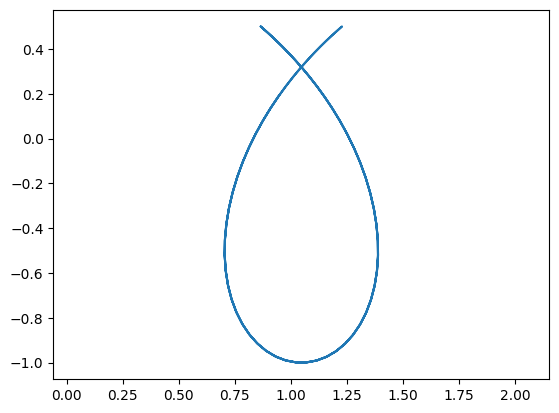

In [130]:
linearized_cartpole_dynamics_example()

In [134]:
def matrix_exp_dynamics(A, b, f, u_k, x_k, delta_t):

    def mat_exp_ish(F, dt):
        return np.eye(np.shape(f)[0]) + F * dt + 0.5 * np.dot(F, F) * (dt**2)

    def some_funk(F, dt):
        # (exp(At) - I) * A^{-1} ~ t + (A t^2)/2 + (A^2 t^3)/3!
        return dt + 0.5 * F * (dt**2) + (1.0/6.0) * np.dot(F, F) * (dt ** 3)

    # return np.dot(mat_exp_ish(A, delta_t), x_k) + np.dot(np.dot((mat_exp_ish(A, dt), np.linalg.inv(A)) - np.eye(np.shape(f)[0])), b * u_k + f)
    return np.dot(mat_exp_ish(A, delta_t), x_k) + np.dot(some_funk(A, dt), b * u_k + f)

In [135]:
def matrix_exp_lin_cp_example():
    u_max = 1.0
    
    # Initial state, used for linearizing dynamics
    # z_0 = np.array([0.0, 2 * np.pi / 3.0, 0.0, 0.0])
    # z_0 = np.array([0.0, 1000.0 * np.pi / 1001.0, 0.0, 0.0])
    z_0 = np.array([0.0, 0.0, 0.0, 0.0])
    z_init = np.array([0.0, 2 * np.pi / 3.0, 0.0, 0.0])
    u_0 = (u_max + u_min) / 2.0
    t_0 = 0.0
    
    F, b, f = linearized_cartpole_dynamics(t_0, z_0, u_0, u_max)

    zs = []
    zs.append(copy.copy(z_init))
    dt = 0.01
    linear_dynamics = lambda t, y: affine_linear_dynamics(t, y, F, f + b * u_0)
    
    for i in range(200):
        # zs.append(rk4(zs[-1], dt * i, dt, linear_dynamics))
        zs.append(matrix_exp_dynamics(F, b, f, u_0, zs[-1], dt))

    def pendulum_position(z, l_pend):
        # z = [cart_pos, pend_angle, cart_pos_speed, pend_angle_speed]
        return np.array([z[0] + l_pend * np.sin(z[1]), -l_pend * np.cos(z[1])])
    
    pendulum_positions = [pendulum_position(z, 1.0) for z in zs]

    fig = plt.figure()
    ax = fig.add_subplot()
    plt.plot([p[0] for p in pendulum_positions], [p[1] for p in pendulum_positions])
    # ax.set_aspect('equal', adjustable='box')
    ax.axis('equal')
    plt.show()

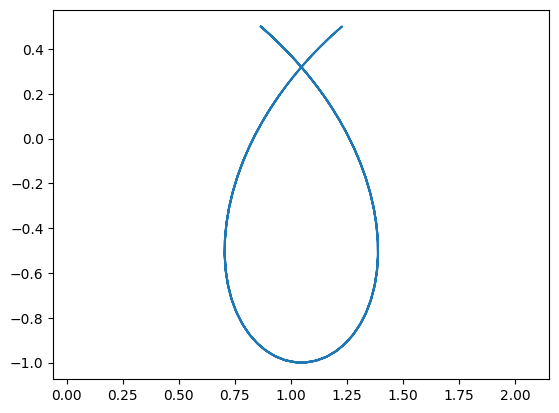

In [136]:
matrix_exp_lin_cp_example()